<a href="https://colab.research.google.com/github/pjjongho/Colab_AD/blob/main/Server%20Shut%20Down%20Anomaly%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Chapter 12]**  
**┗ Server Shut Down Anomaly Detection**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「Data 전처리 및 EDA」
* 🥈Session 2 - 「기간(연도, 월)에 따른 온도 분석」
* 🥇Session 3 - 「이상 탐지 모델링」

In [ ]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/00.Fast_campus/02.Anomaly_detection/03.Part3/Chapter12'

## **문제상황 및 데이터 살펴보기**
---
> **시나리오** ❗

```
A사는 클라우드 저장소 서비스를 제공하는 회사다. 최근 연말 시즌에 돌입하여, 클라우드 서비스를 이용하고 있는 주 소비자인 기업들에 사용량이  
큰 폭으로 증가하고 있는 중이다. 사용자가 급격히 증가함에 따라 서버실에 장비 온도가 급격하게 상승하는 현상들이 발생하여 Server가 Shutdown  
되는 사고가 발생하면서 소비자 불만이 폭주하고 있다. A사는 Server의 장비 온도가 상승하는 이상 현상을 탐지하고, Cooling System을 추가 가동해  
Shut down 사고를 미연의 방지하고자 한다.

```  

> **데이터 살펴보기**

* Server 장비 온도 데이터
* 데이터 명세 ⬇

|Column|Description|
|:---|:---|
|timestamp|시간|
|value|장비 온도|





In [ ]:
# ▶ pd.set option
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# ▶ Data read
df = pd.read_csv("chapter12_df.csv")
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836



## **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ Server 온도 급 상승으로 인한 Server Shut down
▶ 기업(B2B) 사용자 불만 폭주 및 서비스 이탈 고객 발생
```  

> **기대효과**

```
▶ Cooling System 추가 설치 및 운용으로 인해 Shut dwon 방지
▶ Cooling System 최소한의 운영으로 운영 비용 절감
```

> **해결방안**

```
▶ Server 온도가 상승하는 이상 점을 탐지하는 모델 개발 및 운용
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 기간(연도, 월)에 따른 온도 분석
▶ Session 3 🥇
 - 이상 탐지 모델링 수행
```

> **성과측정**  

```
▶ 모델 활용 전/후 Server 장비 온도 모니터링
▶ 모델 활용 전/후 Server Shut down 횟수 비교
▶ 모델 활용 전/후 Cooling System 운영 비용 비교
```

> **현업적용**  

```
▶ Server 장비 온도 데이터 수집 체계 구축
▶ Server 장비 온도 이상점 탐지 시 Alarm 및 Cooling System 추가 가동
```

> **주요 코드 미리 살펴보기**  

```
▶ Session 1 → pd.to_datetime(df['timestamp'])
▶ Session 2 → df['timestamp'].apply(lambda x : x.year), px.violin()
▶ Session 3 →  svm.OneClassSVM(), IsolationForest(), LocalOutlierFactor()
```

## **🥉Session 1**  
**┗ Data 전처리 및 EDA**  
---

### · Data 전처리  
---
* 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인

  (2) Data type 확인

  (3) Null값 확인 (※ 빈 값의 Data)

  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  

In [ ]:
# ▶ Data 형태 확인
# ▶ 22695 row, 2 col로 구성됨
print('df :', df.shape)

df : (22695, 2)


In [ ]:
# ▶ Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [ ]:
# ▶ 시간 Type 변경
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  22695 non-null  datetime64[ns]
 1   value      22695 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 354.7 KB


In [ ]:
# ▶ Null 값 확인
print(df.isnull().sum())

timestamp    0
value        0
dtype: int64


In [ ]:
# ▶ Outlier 확인
df.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


### · Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [ ]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2013-12-02 21:15:00'), Timestamp('2014-02-19 15:25:00'))

In [ ]:
# ▶ 사전에 주어진 Anomaly points
anomaly_points = [
        ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],
        ["2013-12-15 17:50:00.000000","2013-12-17 17:00:00.000000"],
        ["2014-01-27 14:20:00.000000","2014-01-29 13:30:00.000000"],
        ["2014-02-07 14:55:00.000000","2014-02-09 14:05:00.000000"]
]

In [ ]:
anomaly_points

[['2013-12-10 06:25:00.000000', '2013-12-12 05:35:00.000000'],
 ['2013-12-15 17:50:00.000000', '2013-12-17 17:00:00.000000'],
 ['2014-01-27 14:20:00.000000', '2014-01-29 13:30:00.000000'],
 ['2014-02-07 14:55:00.000000', '2014-02-09 14:05:00.000000']]

In [ ]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [ ]:
# ▶ anomaly col 생성
df['anomaly'] = 0
for start, end in anomaly_points:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1

df.head()

,timestamp,value,anomaly
0,2013-12-02 21:15:00,73.967322,0
1,2013-12-02 21:20:00,74.935882,0
2,2013-12-02 21:25:00,76.124162,0
3,2013-12-02 21:30:00,78.140707,0
4,2013-12-02 21:35:00,79.329836,0


In [ ]:
df['anomaly'].value_counts()

0    20427
1     2268
Name: anomaly, dtype: int64

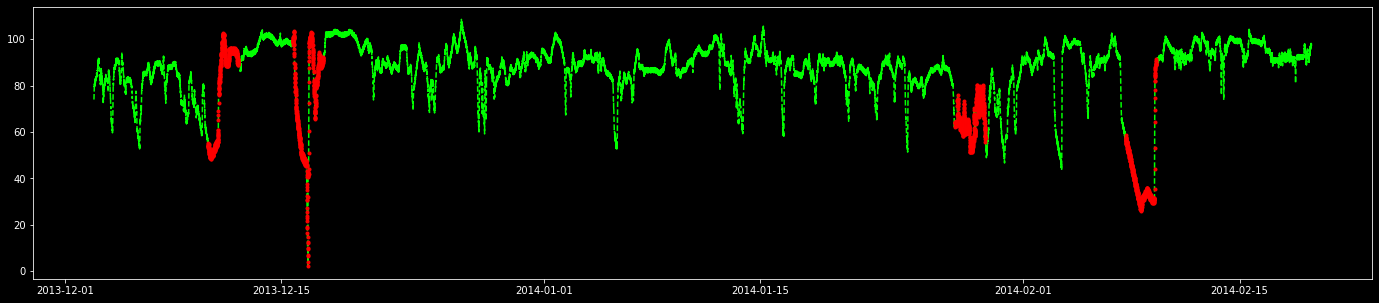

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.figure(figsize=(24,5))
plt.plot(df['timestamp'], df['value'], linestyle='--', color='lime');
plt.plot(df[df['anomaly']==1]['timestamp'], df[df['anomaly']==1]['value'], 'o', color='red', markersize=3);

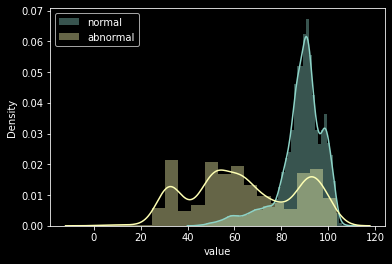

In [ ]:
# ▶ anomaly 온도 분포 비교
sns.distplot(df[df['anomaly']==0]['value'], label = 'normal');
sns.distplot(df[df['anomaly']==1]['value'], label = 'abnormal');
plt.legend()

## **🥈Session 2**  
**┗ 기간(연도, 월)에 따른 온도 분석**  
---

### · Datetime Information
---

In [ ]:
# ▶ 데이터 확인
df.head()

,timestamp,value,anomaly
0,2013-12-02 21:15:00,73.967322,0
1,2013-12-02 21:20:00,74.935882,0
2,2013-12-02 21:25:00,76.124162,0
3,2013-12-02 21:30:00,78.140707,0
4,2013-12-02 21:35:00,79.329836,0


In [ ]:
# ▶ 시간 관련 파생 변수 생성
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)
df['dayofweek'] = df['timestamp'].dt.weekday
df.head()

,timestamp,value,anomaly,year,month,day,hour,minute,dayofweek
0,2013-12-02 21:15:00,73.967322,0,2013,12,2,21,15,0
1,2013-12-02 21:20:00,74.935882,0,2013,12,2,21,20,0
2,2013-12-02 21:25:00,76.124162,0,2013,12,2,21,25,0
3,2013-12-02 21:30:00,78.140707,0,2013,12,2,21,30,0
4,2013-12-02 21:35:00,79.329836,0,2013,12,2,21,35,0


In [ ]:
# ▶ timestamp 인덱스 설정
df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head(3)

,value,anomaly,year,month,day,hour,minute,dayofweek
timestamp,,,,,,,,
2013-12-02 21:15:00,73.967322,0,2013,12,2,21,15,0
2013-12-02 21:20:00,74.935882,0,2013,12,2,21,20,0
2013-12-02 21:25:00,76.124162,0,2013,12,2,21,25,0


### · Year analysis
---

In [ ]:
import plotly.express as px

# ▶ defining functions to create plot
def violin(col):
    fig = px.violin(df, y=col, x="year", color="year", box=True, template = 'plotly_dark')
    fig.update_layout( autosize=False, width=900, height=500)
    return fig.show()

In [ ]:
df['year'] = df['year'].astype(str)

In [ ]:
df_2013 = pd.DataFrame(df[df['year']=='2013']['value'].describe())
df_2013.columns = ['2013_val']
df_2014 = pd.DataFrame(df[df['year']=='2014']['value'].describe())
df_2014.columns = ['2014_val']
pd.concat([df_2013, df_2014], axis=1)

,2013_val,2014_val
count,8385.000000,14310.000000
mean,86.790447,85.420264
std,12.923980,14.182990
min,2.084721,25.887752
25%,82.278758,83.518097
50%,89.011082,89.691431
75%,95.492450,93.270943
max,108.510543,105.594771


In [ ]:
# ▶ violin plot
violin('value')

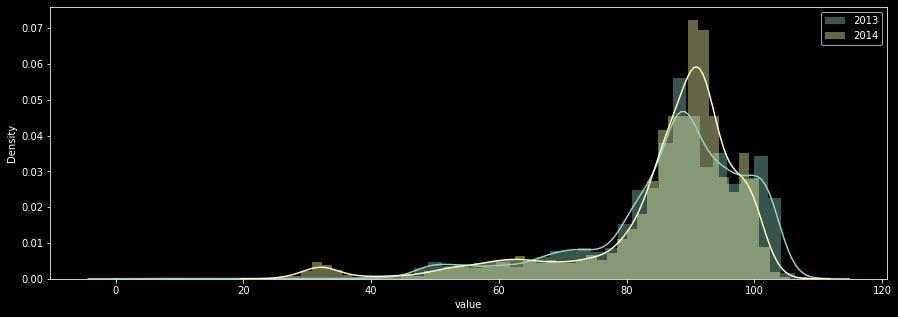

In [ ]:
# ▶ distplot
plt.figure(figsize=(15,5))
sns.distplot(df[df['year']=='2013']['value'], label = '2013');
sns.distplot(df[df['year']=='2014']['value'], label = '2014');
plt.legend()

### · Month analysis
---

In [ ]:
df.head()

,value,anomaly,year,month,day,hour,minute,dayofweek
timestamp,,,,,,,,
2013-12-02 21:15:00,73.967322,0,2013,12,2,21,15,0
2013-12-02 21:20:00,74.935882,0,2013,12,2,21,20,0
2013-12-02 21:25:00,76.124162,0,2013,12,2,21,25,0
2013-12-02 21:30:00,78.140707,0,2013,12,2,21,30,0
2013-12-02 21:35:00,79.329836,0,2013,12,2,21,35,0


In [ ]:
df['month'].value_counts()

1     8940
12    8385
2     5370
Name: month, dtype: int64

In [ ]:
df['month'] = df['month'].astype(str)

In [ ]:
df_12 = pd.DataFrame(df[df['month']=='12']['value'].describe())
df_12.columns = ['12_val']

df_1 = pd.DataFrame(df[df['month']=='1']['value'].describe())
df_1.columns = ['1_val']

df_2 = pd.DataFrame(df[df['month']=='2']['value'].describe())
df_2.columns = ['2_val']

pd.concat([df_12, df_1, df_2], axis=1)

,12_val,1_val,2_val
count,8385.000000,8940.000000,5370.000000
mean,86.790447,84.667239,86.673904
std,12.923980,10.404646,18.797641
min,2.084721,46.627034,25.887752
25%,82.278758,81.754282,89.700417
50%,89.011082,87.094591,92.524268
75%,95.492450,91.092586,97.461016
max,108.510543,105.594771,104.246255


In [ ]:
# ▶ violin plot

def violin(col,value) :
    fig = px.violin(df, y=col, x=value, color=value, box=True, template = 'plotly_dark')
    fig.update_layout( autosize=False, width=900, height=500)
    return fig.show()

violin('value', 'month')

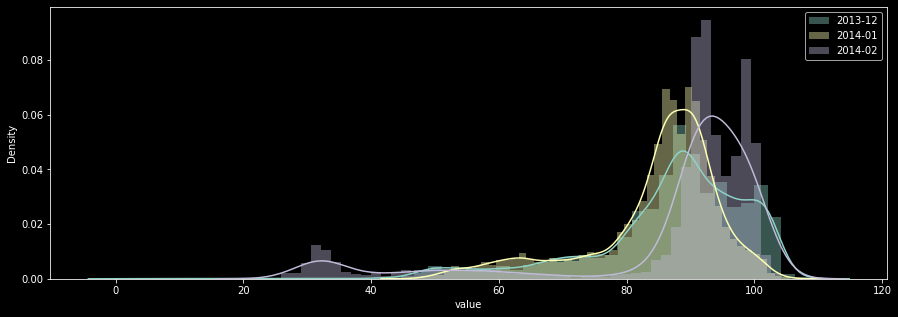

In [ ]:
# ▶ distplot
plt.figure(figsize=(15,5))
sns.distplot(df[df['month']=='12']['value'], label = '2013-12');
sns.distplot(df[df['month']=='1']['value'], label = '2014-01');
sns.distplot(df[df['month']=='2']['value'], label = '2014-02');
plt.legend()

### · Day of the Week analysis
---

In [ ]:
df.head()

,value,anomaly,year,month,day,hour,minute,dayofweek
timestamp,,,,,,,,
2013-12-02 21:15:00,73.967322,0,2013,12,2,21,15,0
2013-12-02 21:20:00,74.935882,0,2013,12,2,21,20,0
2013-12-02 21:25:00,76.124162,0,2013,12,2,21,25,0
2013-12-02 21:30:00,78.140707,0,2013,12,2,21,30,0
2013-12-02 21:35:00,79.329836,0,2013,12,2,21,35,0


In [ ]:
df['dayofweek'] = df['dayofweek'].astype(str)

In [ ]:
df_0 = pd.DataFrame(df[df['dayofweek']=='0']['value'].describe())
df_0.columns = ['0_val']

df_1 = pd.DataFrame(df[df['dayofweek']=='1']['value'].describe())
df_1.columns = ['1_val']

df_2 = pd.DataFrame(df[df['dayofweek']=='2']['value'].describe())
df_2.columns = ['2_val']

df_3 = pd.DataFrame(df[df['dayofweek']=='3']['value'].describe())
df_3.columns = ['3_val']

df_4 = pd.DataFrame(df[df['dayofweek']=='4']['value'].describe())
df_4.columns = ['4_val']

df_5 = pd.DataFrame(df[df['dayofweek']=='5']['value'].describe())
df_5.columns = ['5_val']

df_6 = pd.DataFrame(df[df['dayofweek']=='6']['value'].describe())
df_6.columns = ['6_val']

pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6], axis=1)

,0_val,1_val,2_val,3_val,4_val,5_val,6_val
count,3201.000000,3468.000000,3354.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,80.993944,84.413051,89.518365,88.270918,87.228534,84.642035,86.402453
std,14.755806,13.101354,10.140944,12.078953,11.329262,17.307002,14.620711
min,2.084721,48.387890,48.927015,46.627034,45.351142,25.887752,29.426162
25%,72.692461,81.218208,85.592296,84.581206,84.327296,83.282618,85.271162
50%,85.666337,88.865955,90.805263,90.971473,89.521915,89.214130,89.284308
75%,91.055923,92.816698,96.440877,96.509440,94.435313,93.467022,94.734682
max,102.984833,103.199895,105.594771,108.510543,103.968521,104.246255,103.620535


In [ ]:
# ▶ violin plot
# def violin(col):
#     fig = px.violin(df, y=col, x="dayofweek", color="dayofweek", box=True, template = 'plotly_dark')
#     fig.update_layout( autosize=False, width=900, height=500)
#     return fig.show()

violin('value', 'dayofweek')

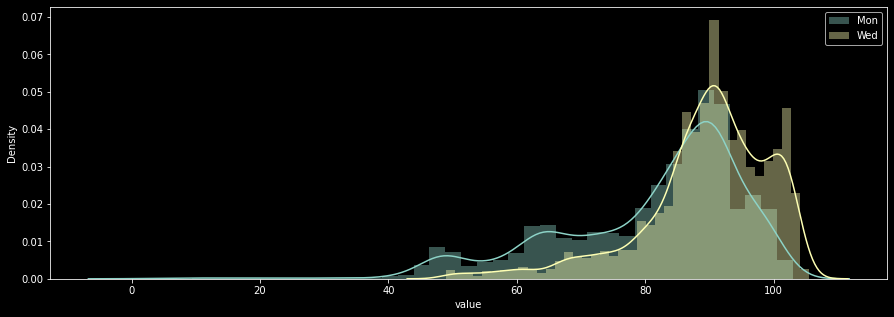

In [ ]:
# ▶ dist plot
plt.figure(figsize=(15,5))
sns.distplot(df[df['dayofweek']=='0']['value'], label = 'Mon');
#sns.distplot(df[df['dayofweek']=='1']['value'], label = 'Tue');
sns.distplot(df[df['dayofweek']=='2']['value'], label = 'Wed');
# sns.distplot(df[df['dayofweek']=='3']['value'], label = 'Thr');
# sns.distplot(df[df['dayofweek']=='4']['value'], label = 'Fri');
# sns.distplot(df[df['dayofweek']=='5']['value'], label = 'Sat');
# sns.distplot(df[df['dayofweek']=='6']['value'], label = 'Sun');
plt.legend()

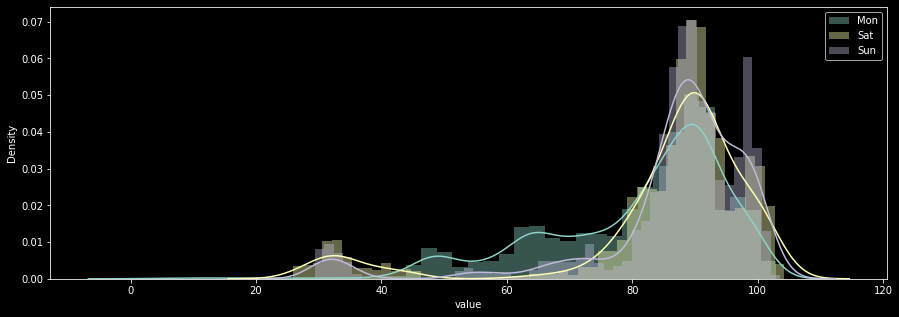

In [ ]:
# ▶ 평일, 주말 비교
plt.figure(figsize=(15,5))
sns.distplot(df[df['dayofweek']=='0']['value'], label = 'Mon');
sns.distplot(df[df['dayofweek']=='5']['value'], label = 'Sat');
sns.distplot(df[df['dayofweek']=='6']['value'], label = 'Sun');
plt.legend()

## **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · Model Selection
---
* One class SVM Anomaly Detection

```
# 코드로 형식 지정됨
```


```
# Unsupervised Anomaly Deteciotn 중 하나의 기법
# 데이터를 N차원 좌표축으로 표현하고, 원점과의 거리를 기준으로 초평면(Hyper plane)을 그어 Classification하는 방법
# SVM(Support Vector Machine)은 Binary-Classification에 활용되며 Support Vector 간의 Margine을 기준으로 Hyper Plane을 나눔
# 반면 OCSVM은 원점을 기준으로 정상과 이상에 대한 Hyper Plane을 찾는 방법
# 일반적으로 Linear Support Vector Machine을 이용하지만, 영역의 구분이 복잡해지면 RBF(Radial Basis Functions)와 같은 커널 함수를 사용
# 선형으로 데이터를 분리할 수 없을때 RBF(방사형) 커널 활용
# Loss 함수 : min(Abnormal 데이터들과 Hyper Plane 사이의 거리)
```
<img src = "https://drive.google.com/uc?id=1q1-76h31hhpwXrNMQ3ZyuBWX2xXcxFTF" width="500" height="400">

* 장단점
```
  # [good] 데이터 Label이 존재하지 않아도 사용 가능
  # [good] 저차원이나 고차원의 적은 데이터에서 일반화 능력이 좋음
  # [good] 데이터 특성이 적어도 성능이 좋게 나오는 편, Robust 함
  # [bad] Kernel 기반의 방법론, 데이터가 늘어날 수록 연산량이 크게 증가함
  # [bad] Scaling에 민감함
  # [bad] Hyper parameter 조절을 잘 해야 최적의 모델을 구할 수 있음
```

### · (1) OneClassSVM modeling
---

In [ ]:
df.head()

,value,anomaly,year,month,day,hour,minute,dayofweek
timestamp,,,,,,,,
2013-12-02 21:15:00,73.967322,0,2013,12,2,21,15,0
2013-12-02 21:20:00,74.935882,0,2013,12,2,21,20,0
2013-12-02 21:25:00,76.124162,0,2013,12,2,21,25,0
2013-12-02 21:30:00,78.140707,0,2013,12,2,21,30,0
2013-12-02 21:35:00,79.329836,0,2013,12,2,21,35,0


In [ ]:
ocsvm_df['value'] = df['value'].values

In [ ]:
from sklearn import svm
ocsvm_model = svm.OneClassSVM(nu=0.2, gamma=0.001, kernel='rbf')
ocsvm_ret = ocsvm_model.fit_predict(df['value'].values.reshape(-1, 1))
ocsvm_df = pd.DataFrame()

ocsvm_df['timestamp'] = df.index
#ocsvm_df.set_index(['timestamp'], inplace =True)
ocsvm_df['value'] = df['value'].values
ocsvm_df['anomaly']  = [1 if i==-1 else 0 for i in ocsvm_ret]

In [ ]:
ocsvm_df.head()

,timestamp,value,anomaly
0,2013-12-02 21:15:00,73.967322,0
1,2013-12-02 21:20:00,74.935882,0
2,2013-12-02 21:25:00,76.124162,0
3,2013-12-02 21:30:00,78.140707,0
4,2013-12-02 21:35:00,79.329836,0


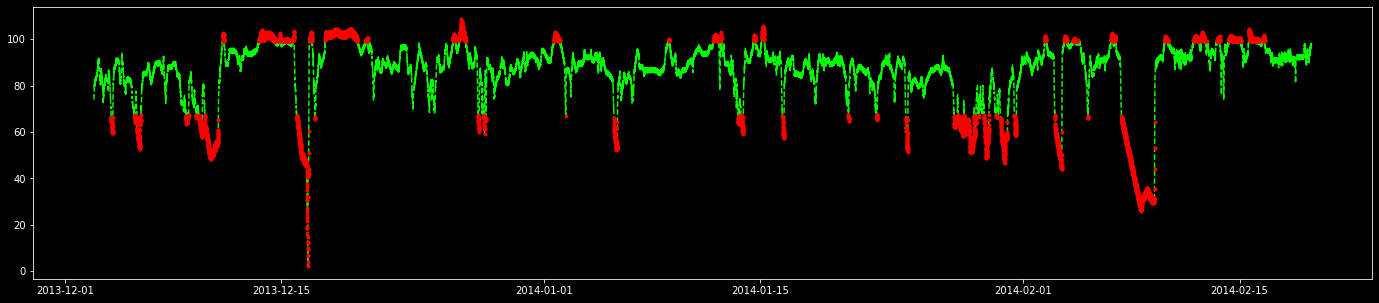

In [ ]:
# ▶ predict data
plt.figure(figsize=(24,5))
plt.plot(ocsvm_df['timestamp'], ocsvm_df['value'], linestyle='--', color='lime');
plt.plot(ocsvm_df[ocsvm_df['anomaly']==1]['timestamp'], ocsvm_df[ocsvm_df['anomaly']==1]['value'], 'o', color='red', markersize=3);

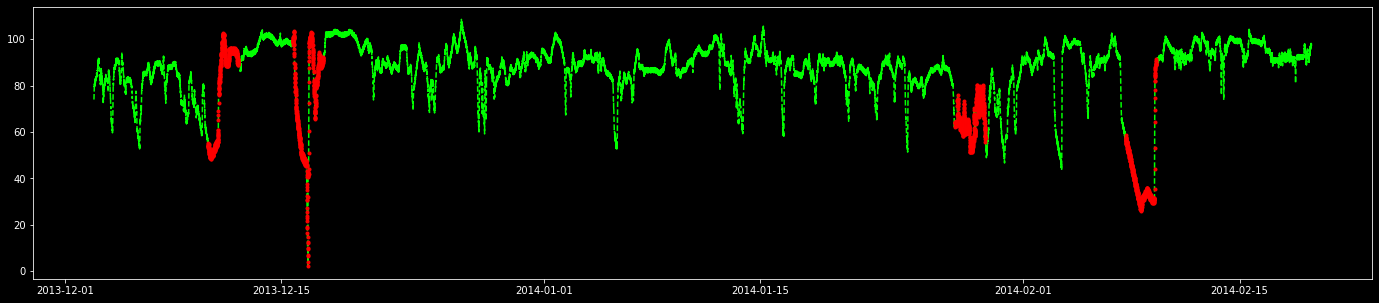

In [ ]:
# ▶ raw data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

plt.figure(figsize=(24,5))
plt.plot(df.index, df['value'], linestyle='--', color='lime');
plt.plot(df[df['anomaly']==1].index, df[df['anomaly']==1]['value'], 'o', color='red', markersize=3);

In [ ]:
# ▶ 성능평가
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

ocsvm_f1 = f1_score(df['anomaly'], ocsvm_df['anomaly'])
print(classification_report(ocsvm_df['anomaly'], df['anomaly']))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     18155
           1       0.63      0.32      0.42      4540

    accuracy                           0.83     22695
   macro avg       0.74      0.64      0.66     22695
weighted avg       0.81      0.83      0.80     22695



### · (2) Isolation-Forest modeling
---

In [ ]:
from sklearn.ensemble import IsolationForest

iforest_model = IsolationForest(n_estimators=300, contamination=0.1, max_samples=700)
iforest_ret = iforest_model.fit_predict(df['value'].values.reshape(-1, 1))
iforest_df = pd.DataFrame()

iforest_df['timestamp'] = df.index
iforest_df['value'] = df['value'].values
iforest_df['anomaly']  = [1 if i==-1 else 0 for i in iforest_ret]

In [ ]:
iforest_df['anomaly'].value_counts()

0    20425
1     2270
Name: anomaly, dtype: int64

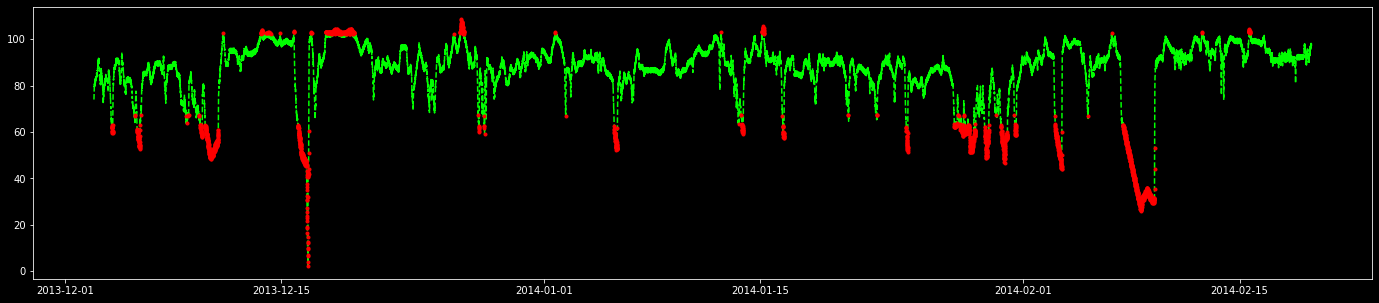

In [ ]:
# ▶ predict data
plt.figure(figsize=(24,5))
plt.plot(iforest_df['timestamp'], iforest_df['value'], linestyle='--', color='lime');
plt.plot(iforest_df[iforest_df['anomaly']==1]['timestamp'], iforest_df[iforest_df['anomaly']==1]['value'], 'o', color='red', markersize=3);

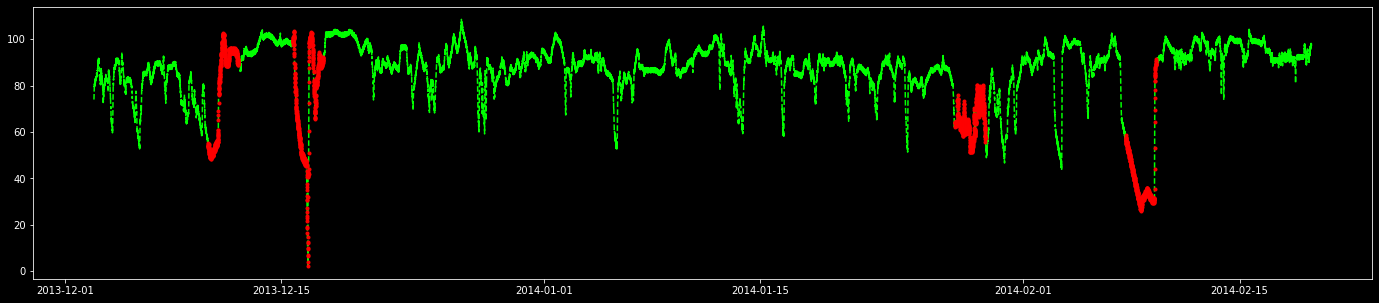

In [ ]:
# ▶ raw data
plt.figure(figsize=(24,5))
plt.plot(df.index, df['value'], linestyle='--', color='lime');
plt.plot(df[df['anomaly']==1].index, df[df['anomaly']==1]['value'], 'o', color='red', markersize=3);

In [ ]:
# ▶ 성능평가
from sklearn.metrics import classification_report

iforest_f1 = f1_score(df['anomaly'], iforest_df['anomaly'])
print(classification_report(iforest_df['anomaly'], df['anomaly']))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     20425
           1       0.52      0.52      0.52      2270

    accuracy                           0.90     22695
   macro avg       0.73      0.73      0.73     22695
weighted avg       0.90      0.90      0.90     22695



### · (3) LOF modeling
---

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof_model = LocalOutlierFactor(n_neighbors=10000, contamination=0.1)
lof_ret = lof_model.fit_predict(df['value'].values.reshape(-1, 1))
lof_df = pd.DataFrame()

lof_df['timestamp'] = df.index
lof_df['value'] = df['value'].values
lof_df['anomaly']  = [1 if i==-1 else 0 for i in lof_ret]

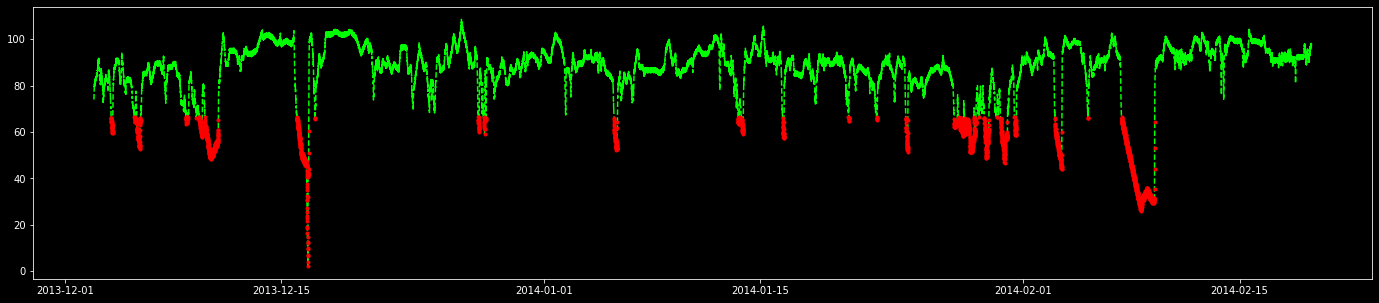

In [ ]:
# predict data
plt.figure(figsize=(24,5))
plt.plot(lof_df['timestamp'], lof_df['value'], linestyle='--', color='lime');
plt.plot(lof_df[lof_df['anomaly']==1]['timestamp'], lof_df[lof_df['anomaly']==1]['value'], 'o', color='red', markersize=3);

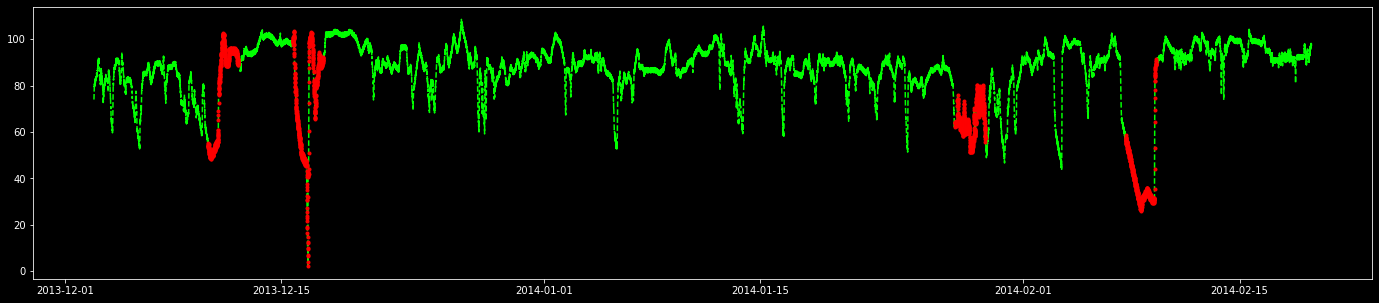

In [ ]:
# raw data
plt.figure(figsize=(24,5))
plt.plot(df['timestamp'], df['value'], linestyle='--', color='lime');
plt.plot(df[df['anomaly']==1]['timestamp'], df[df['anomaly']==1]['value'], 'o', color='red', markersize=3);

In [ ]:
# ▶ 성능평가
from sklearn.metrics import classification_report

lof_f1 = f1_score(df['anomaly'], lof_df['anomaly'])
print(classification_report(lof_df['anomaly'], df['anomaly']))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     20425
           1       0.58      0.58      0.58      2270

    accuracy                           0.92     22695
   macro avg       0.77      0.77      0.77     22695
weighted avg       0.92      0.92      0.92     22695



### · (4) Variance Based Method modeling
---

In [ ]:
sigma_df = pd.DataFrame()
sigma_df['timestamp'] = df.index
sigma_df['value'] = df['value'].values

mean = sigma_df['value'].mean()
std = sigma_df['value'].std()

sigma_df['anomaly_threshold_3r'] = mean + 1.7*std
sigma_df['anomaly_threshold_3l'] = mean - 1.7*std
sigma_df['anomaly']  = sigma_df.apply(lambda x : 1 if (x['value'] > x['anomaly_threshold_3r']) or (x['value'] < x['anomaly_threshold_3l']) else 0, axis=1)

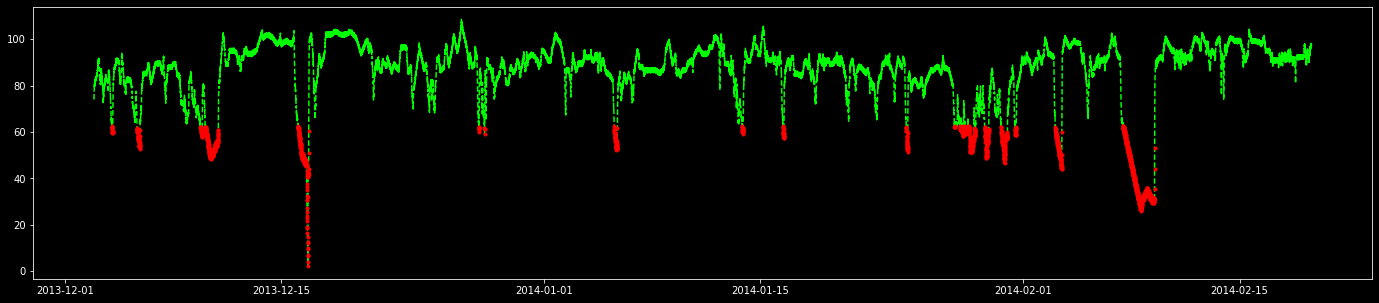

In [ ]:
# ▶ predict data
plt.figure(figsize=(24,5))
plt.plot(sigma_df['timestamp'], sigma_df['value'], linestyle='--', color='lime');
plt.plot(sigma_df[sigma_df['anomaly']==1]['timestamp'], sigma_df[sigma_df['anomaly']==1]['value'], 'o', color='red', markersize=3);

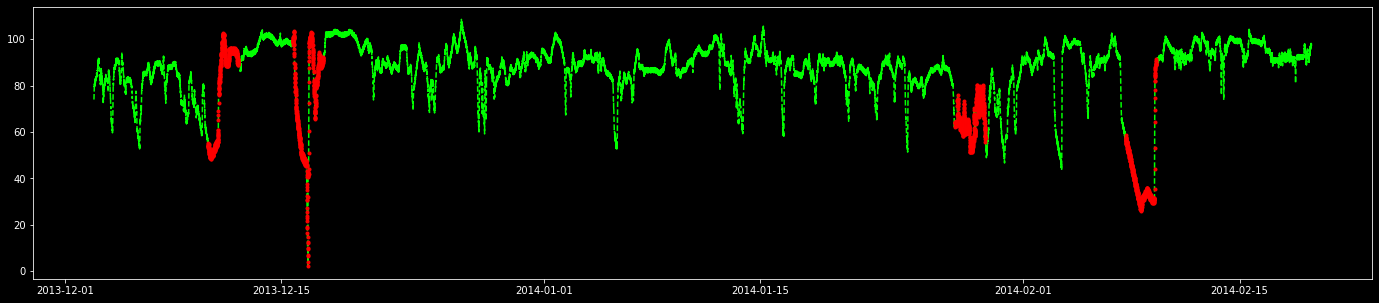

In [ ]:
# ▶ raw data
plt.figure(figsize=(24,5))
plt.plot(df.index, df['value'], linestyle='--', color='lime');
plt.plot(df[df['anomaly']==1].index, df[df['anomaly']==1]['value'], 'o', color='red', markersize=3);

In [ ]:
# ▶ 성능평가
from sklearn.metrics import classification_report

sigma_f1 = f1_score(df['anomaly'], sigma_df['anomaly'])
print(classification_report(sigma_df['anomaly'], df['anomaly']))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     20879
           1       0.51      0.64      0.57      1816

    accuracy                           0.92     22695
   macro avg       0.74      0.79      0.76     22695
weighted avg       0.93      0.92      0.93     22695



### · Model comparison
---

In [ ]:
models = pd.DataFrame({
    'Model' : [ 'ocsvm_f1', 'iforest_f1','lof_f1', 'sigma_f1'],
    'Score(f1)' : [ocsvm_f1, iforest_f1, lof_f1, sigma_f1]
})

models.sort_values(by = 'Score(f1)', ascending = False)

,Model,Score(f1)
2,lof_f1,0.584398
3,sigma_f1,0.565622
1,iforest_f1,0.521816
0,ocsvm_f1,0.422444
